<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:2%; font-size:50px">Bees, Wasps or Other Insects</h1>
<hr>
<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Imports</h1>


In [86]:
import os
import PIL
import cv2
import math
import random
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, \
classification_report, log_loss ,precision_recall_curve, balanced_accuracy_score

<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Constants and Global Variables</h1>


In [87]:
DATASET_PATH = '../Datasets/On Door/'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
SAMPLE_RATE = 22050

In [88]:
models = {
    'buzzingDetection':layers.SimpleRNN, 
    'insectDetection': None, 
    'beeOrNot': None, 
    'waspOrNot': None, 
    'decisionMaking': None
    }
datasets = ['BuzzOrNot', 'BeeOrNot', 'WaspOrNot']

<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Evaluation</h1>


In [89]:
def evaluateModel(yTrue, yPred, yProb=None):
    accuracy = accuracy_score(yTrue, yPred)
    print(f"Accuracy: {accuracy:.4f}")
    
    balancedAcc = balanced_accuracy_score(yTrue, yPred)
    print(f"Balanced Accuracy: {balancedAcc:.4f}")
    
    precision = precision_score(yTrue, yPred)
    print(f"Precision: {precision:.4f}")
    
    recall = recall_score(yTrue, yPred)
    print(f"Recall: {recall:.4f}")
    
    f1 = f1_score(yTrue, yPred)
    print(f"F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(yTrue, yPred)
    print(f"Confusion Matrix:\n{cm}")
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if yProb is not None:
        rocAuc = roc_auc_score(yTrue, yProb)
        print(f"ROC AUC Score: {rocAuc:.4f}")
        
        fpr, tpr, _ = roc_curve(yTrue, yProb)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {rocAuc:.4f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
        
        precisionCurve, recallCurve, _ = precision_recall_curve(yTrue, yProb)
        plt.figure(figsize=(6, 4))
        plt.plot(recallCurve, precisionCurve, label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend(loc="lower left")
        plt.show()

    if yProb is not None:
        logloss = log_loss(yTrue, yProb)
        print(f"Log Loss: {logloss:.4f}")

<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:1%">Buzz Detection (Sound Classification)</h1>


---


<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Audio Segmentation</h2>


In [90]:
def loadAudio(sub='/train'):
    print(f"\nLoading audio data from {DATASET_PATH + datasets[0] + sub}...")
    PATH = DATASET_PATH + datasets[0] + sub
    segments = []
    targets = []
    
    for filename in os.listdir(PATH):
        if filename.endswith('.wav'):
            audio = os.path.join(PATH, filename)
            label = filename.split('.')[0].split('_')[0]
            try:
                audio, sampleRate = librosa.load(audio)
                segments.append(audio)
                targets.append('Buzzing' if filename.startswith( 'Bee') else 'No Buzzing')
            except:
                os.remove(audio)
  
    return segments, np.array(targets)       

<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Audio Pre-Proccessing</h2>


In [91]:
def extractMFCC(segments, n_mfcc=12):
    print(f"\nPadded MFCC extraction for {len(segments)} segments...")
    mfccs = []
    mfccs = [librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE, n_mfcc=n_mfcc) for segment in segments]
    return mfccs, max([mfcc.shape[1] for mfcc in mfccs])


In [92]:
def pad(mfccs, maxLength):
    features = [
        np.pad(mfcc, ((0, 0), (0, maxLength - mfcc.shape[1])), mode='constant') 
        for mfcc in mfccs
    ]
    return np.array(features)

<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Audio PipeLine</h2>


In [93]:
def audioPipeline():
    xTrain, yTrain = loadAudio('/train/')
    xTest, yTest = loadAudio('/test/')
    xTrain, maxTrainLength = extractMFCC(xTrain)
    xTest, maxTestLength = extractMFCC(xTest)
    xTrain = pad(xTrain, max(maxTrainLength, maxTestLength))
    xTest = pad(xTest, max(maxTrainLength, maxTestLength))
    yTrain = np.array([1 if label == 'Buzzing' else 0 for label in yTrain])
    yTest = np.array([1 if label == 'Buzzing' else 0 for label in yTest])
    xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)
    return xTrain, yTrain, xVal, yVal, xTest, yTest

<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:1%">Bee Detection (Image Classification)</h1>
<hr>
<h2 style="font-family:'Georgia'; font-weight:bold;padding:1%">Loading Images</h2>


In [94]:
def loadImages(index, sub, positive):
    print(f"\nLoading image data from {DATASET_PATH + datasets[index] + sub}...")
    PATH = DATASET_PATH + datasets[index] + sub
    subDirs = [d for d in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, d))]
    targets = []
    images = []
    
    for target in subDirs:
        targetPath = os.path.join(PATH, target)   
        
        for filename in os.listdir(targetPath):
            if filename.endswith(('.jpg', '.png')): 
                image = os.path.join(targetPath, filename)
                img = cv2.imread(image)
                img = cv2.resize(img, IMAGE_SIZE) 
                targets.append(target)
                images.append(img)
    targets = np.array([1 if target == positive else 0 for target in targets])            
    return np.array(images), np.array(targets)

In [95]:
def extractImages(index, positive):
    xTrain, yTrain = loadImages(index, '/train/', positive)
    xTest, yTest = loadImages(index, '/test/', positive)
    xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)
    
    return xTrain, yTrain, xVal, yVal, xTest, yTest

<h1 style="font-family:'Georgia'; font-weight:bold;padding:1%">Model Building</h1>


In [96]:
def buildForBuzz(shape, modelType):  
        print(f"\nBuilding {modelType.__name__} with input shape {shape}...")
        model = Sequential()
        model.add(layers.Input(shape=shape))
        
        model.add(modelType(128, return_sequences=True))
        model.add(modelType(64))
        #model.add(layers.Dense(64, activation='tanh'))

        
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        return model

In [97]:
def buildForInsects(baseModel):
    model = Sequential()
    base = baseModel(weights='imagenet', include_top=False,
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),pooling='avg')
    
    for layer in base.layers:
        layer.trainable=False
        
    model.add(base)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [98]:
def train(model, xTrain, yTrain, xVal, yVal):
    print(f"\nTraining {model.layers[0].__class__.__name__} model...")
    model.fit(xTrain, yTrain, validation_data=(xVal, yVal), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True)
    predictions = model.predict(xVal)
    predictions = np.array([1 if pred > 0.5 else 0 for pred in predictions])
    evaluateModel(yVal, predictions)
    return model

In [99]:
def test(model, xTest, yTest):
    predictions = model.predict(xTest)
    predictions = np.array([1 if pred > 0.5 else 0 for pred in predictions])
    evaluateModel(yTest, predictions)

<h1 align="center" style="font-family:'Georgia'; font-weight:bold;padding:2%">Main</h1>


In [ ]:
def compareAudioModels(): 
    xTrain, yTrain, xVal, yVal, xTest, yTest = audioPipeline()
    models = [layers.LSTM, layers.GRU, layers.SimpleRNN]
    for model in models:
        model = buildForBuzz(xTrain.shape[1:], model)
        model = train(model, xTrain, yTrain, xVal, yVal)
        test(model, xTest, yTest)
        
compareAudioModels()


Loading audio data from ../Datasets/On Door/BuzzOrNot/train/...


In [100]:
def classifyInsects(index=1, positive="Bee"):
    xTrain, yTrain, xVal, yVal, xTest, yTest = extractImages(index, positive)
    baseModels = {'VGG':tf.keras.applications.VGG16 ,'mobileNet':tf.keras.applications.MobileNetV3Large,'resNet': tf.keras.applications.ResNet50}
    trainedModels ={}
    for modelName,modelType in baseModels.items():
        print(f"{modelName}:\n")
        print(modelType)
        model = buildForInsects(modelType);
        model = train(model, xTrain, yTrain, xVal, yVal)
        test(model, xTest, yTest)
        trainedModels[modelName] = model
    return trainedModels, xTest, yTest

In [101]:
def show(model, image, label, positive, negative):
    reshapedImg = np.expand_dims(image, axis=0)
    prediction = model.predict(reshapedImg)
    print(prediction)
    print('Predicted:', positive if prediction[0][0] > 0.5 else negative)
    print('True label:', positive if label == 1 else negative)
    cv2.imshow('Test Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def demo(beeModel, waspModel, image, label):
    show(beeModel, image, label, "Bee", "Not Bee") 
    reshapedImg = np.expand_dims(image, axis=0)
    prediction = beeModel.predict(reshapedImg)
    
    if prediction[0][0] <= 0.5: 
        show(waspModel, image, label, "Wasp", "Other Insects")


Loading image data from ../Datasets/On Door/BeeOrNot/train/...

Loading image data from ../Datasets/On Door/BeeOrNot/test/...
VGG:

<function VGG16 at 0x000002111DFA7C40>
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 60s 1us/step

Training Functional model...
Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 642s 3s/step - accuracy: 0.7861 - loss: 0.8668 - val_accuracy: 0.8718 - val_loss: 0.3188
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.8855 - loss: 0.2685 - val_accuracy: 0.8837 - val_loss: 0.2828
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.9055 - loss: 0.2224 - val_accuracy: 0.8827 - val_loss: 0.3049
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 619s 2s/step - accuracy: 0.9188 - loss: 0.1986 - val_accuracy: 0.8723 - val_loss: 0.3124
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.9148 - loss: 0.2056 - val_accuracy: 0.8748 - val_loss: 0.2994
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.9205 - loss: 0.1797 - val_accuracy

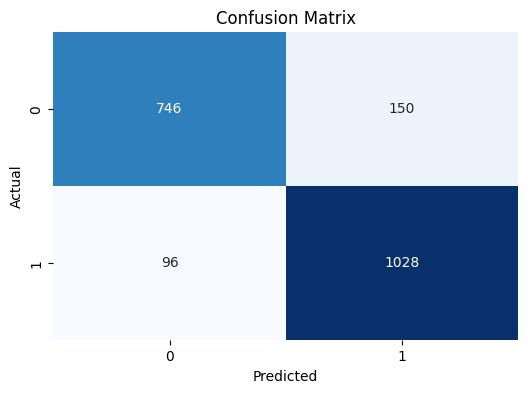

66/66 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step
Accuracy: 0.8968
Balanced Accuracy: 0.8964
Precision: 0.8754
Recall: 0.9279
F1 Score: 0.9009
Confusion Matrix:
[[903 141]
 [ 77 991]]


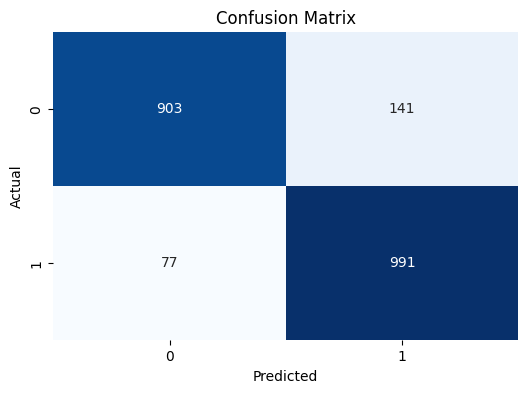

mobileNet:

<function MobileNetV3Large at 0x000002111DFA5DA0>
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step

Training Functional model...
Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 222s 858ms/step - accuracy: 0.8542 - loss: 0.3381 - val_accuracy: 0.8847 - val_loss: 0.2650
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 222s 877ms/step - accuracy: 0.9016 - loss: 0.2346 - val_accuracy: 0.8871 - val_loss: 0.2583
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 228s 900ms/step - accuracy: 0.9086 - loss: 0.2175 - val_accuracy: 0.8866 - val_loss: 0.2602
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 209s 826ms/step - accuracy: 0.9069 - loss: 0.2058 - val_accuracy: 0.8931 - val_loss: 0.2473
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 214s 845ms/step - accuracy: 0.9282 - loss: 0.1665 - val_accuracy: 0.8876 - val_loss: 0.2549
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 206s 816ms/step - accuracy: 0.9344 - loss: 0.1558 - val_accuracy: 0.8936 - val_loss: 0.2695
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 212s 840ms/step - accura

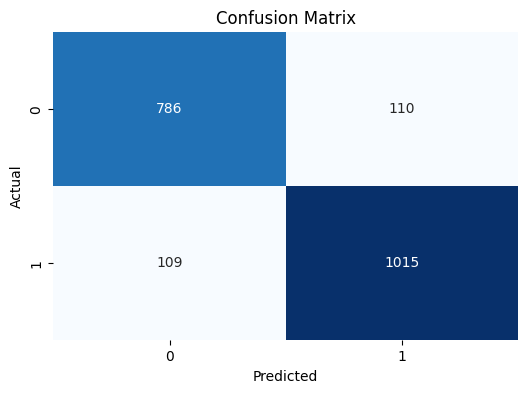

66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 615ms/step
Accuracy: 0.8987
Balanced Accuracy: 0.8986
Precision: 0.8946
Recall: 0.9064
F1 Score: 0.9005
Confusion Matrix:
[[930 114]
 [100 968]]


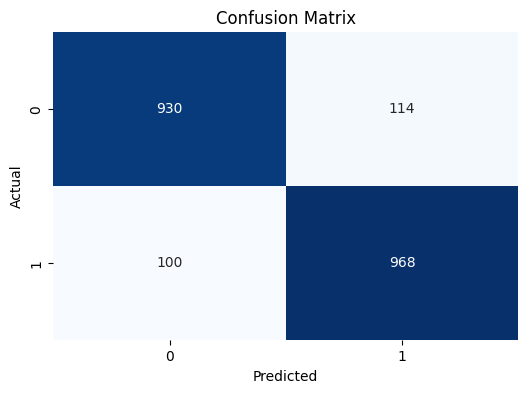

resNet:

<function ResNet50 at 0x000002111DFA7060>

Training Functional model...
Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.8174 - loss: 0.4134 - val_accuracy: 0.8832 - val_loss: 0.2685
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.8808 - loss: 0.2600 - val_accuracy: 0.8837 - val_loss: 0.2624
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.8922 - loss: 0.2419 - val_accuracy: 0.8837 - val_loss: 0.2536
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.9063 - loss: 0.2164 - val_accuracy: 0.8980 - val_loss: 0.2490
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.9036 - loss: 0.2132 - val_accuracy: 0.8921 - val_loss: 0.2596
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.9039 - loss: 0.2115 - val_accuracy: 0.8941 - val_loss: 0.2747
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.9216 - loss: 0.1857 - val_accuracy: 0.8792 - val_loss: 0.2960
Epoch 8/10
253/2

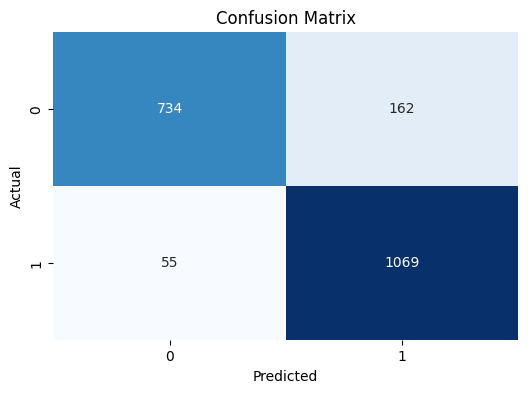

66/66 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step
Accuracy: 0.8949
Balanced Accuracy: 0.8943
Precision: 0.8591
Recall: 0.9476
F1 Score: 0.9012
Confusion Matrix:
[[ 878  166]
 [  56 1012]]


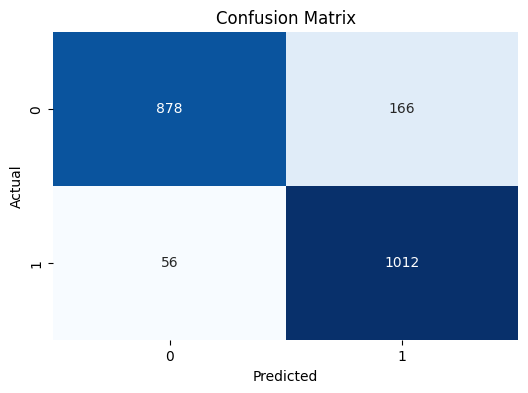


Loading image data from ../Datasets/On Door/WaspOrNot/train/...

Loading image data from ../Datasets/On Door/WaspOrNot/test/...
VGG:

<function VGG16 at 0x000002111DFA7C40>

Training Functional model...
Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 1099s 3s/step - accuracy: 0.7491 - loss: 0.7491 - val_accuracy: 0.8202 - val_loss: 0.3913
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 1026s 2s/step - accuracy: 0.8443 - loss: 0.3280 - val_accuracy: 0.8291 - val_loss: 0.3535
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 1089s 3s/step - accuracy: 0.8613 - loss: 0.2870 - val_accuracy: 0.8286 - val_loss: 0.3642
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 1048s 2s/step - accuracy: 0.8738 - loss: 0.2610 - val_accuracy: 0.8231 - val_loss: 0.4023
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 1049s 2s/step - accuracy: 0.8908 - loss: 0.2267 - val_accuracy: 0.8367 - val_loss: 0.3511
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 1075s 2s/step - accuracy: 0.8972 - loss: 0.2185 - val_accuracy: 0.8453 - val_loss: 0.3574
Epoch 7/10
433/4

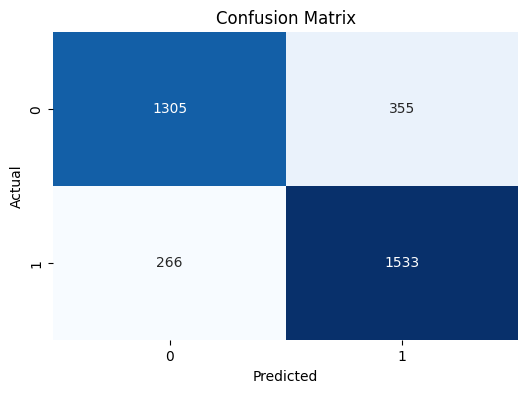

261/261 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step
Accuracy: 0.9062
Balanced Accuracy: 0.8637
Precision: 0.9307
Recall: 0.9465
F1 Score: 0.9385
Confusion Matrix:
[[1582  444]
 [ 337 5961]]


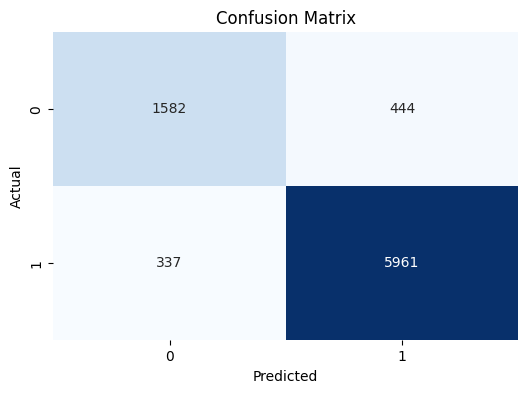

mobileNet:

<function MobileNetV3Large at 0x000002111DFA5DA0>

Training Functional model...
Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 366s 834ms/step - accuracy: 0.7985 - loss: 0.4296 - val_accuracy: 0.8410 - val_loss: 0.3222
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 354s 819ms/step - accuracy: 0.8540 - loss: 0.3015 - val_accuracy: 0.8369 - val_loss: 0.3304
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 355s 821ms/step - accuracy: 0.8829 - loss: 0.2570 - val_accuracy: 0.8534 - val_loss: 0.3141
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 356s 823ms/step - accuracy: 0.8884 - loss: 0.2335 - val_accuracy: 0.8430 - val_loss: 0.3376
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 354s 818ms/step - accuracy: 0.8984 - loss: 0.2121 - val_accuracy: 0.8609 - val_loss: 0.3075
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 355s 821ms/step - accuracy: 0.9082 - loss: 0.1962 - val_accuracy: 0.8384 - val_loss: 0.3382
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 361s 833ms/step - accuracy: 0.9091 - loss: 0.1851 - val_accuracy: 0.8569 - v

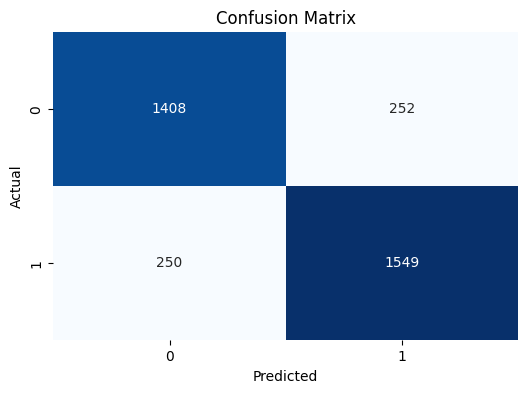

261/261 ━━━━━━━━━━━━━━━━━━━━ 170s 649ms/step
Accuracy: 0.9204
Balanced Accuracy: 0.8844
Precision: 0.9411
Recall: 0.9544
F1 Score: 0.9477
Confusion Matrix:
[[1650  376]
 [ 287 6011]]


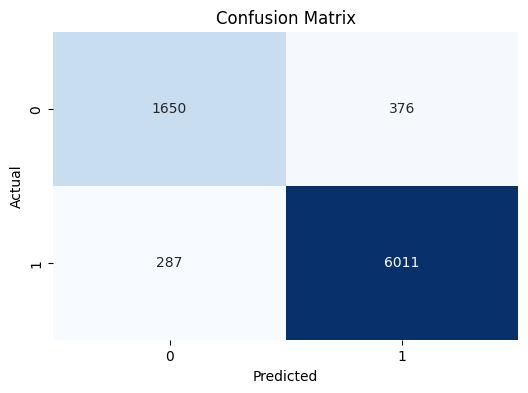

resNet:

<function ResNet50 at 0x000002111DFA7060>

Training Functional model...
Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 987s 2s/step - accuracy: 0.7818 - loss: 0.4945 - val_accuracy: 0.8184 - val_loss: 0.3552
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 948s 2s/step - accuracy: 0.8564 - loss: 0.3072 - val_accuracy: 0.8277 - val_loss: 0.3365
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 938s 2s/step - accuracy: 0.8692 - loss: 0.2723 - val_accuracy: 0.8208 - val_loss: 0.3395
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 935s 2s/step - accuracy: 0.8810 - loss: 0.2502 - val_accuracy: 0.8416 - val_loss: 0.3266
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 935s 2s/step - accuracy: 0.8888 - loss: 0.2329 - val_accuracy: 0.8367 - val_loss: 0.3501
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 936s 2s/step - accuracy: 0.8977 - loss: 0.2179 - val_accuracy: 0.8500 - val_loss: 0.3030
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 934s 2s/step - accuracy: 0.9040 - loss: 0.1973 - val_accuracy: 0.8534 - val_loss: 0.3233
Epoch 8/10
433/4

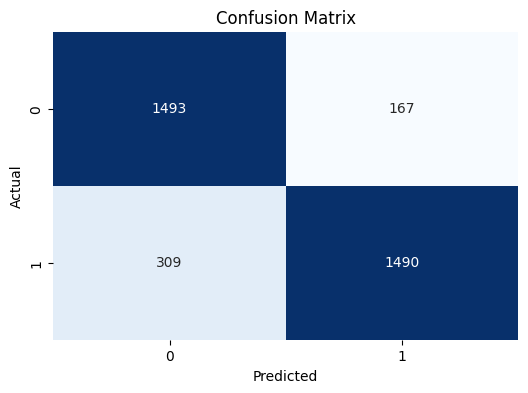

261/261 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step
Accuracy: 0.9318
Balanced Accuracy: 0.9159
Precision: 0.9624
Recall: 0.9468
F1 Score: 0.9545
Confusion Matrix:
[[1793  233]
 [ 335 5963]]


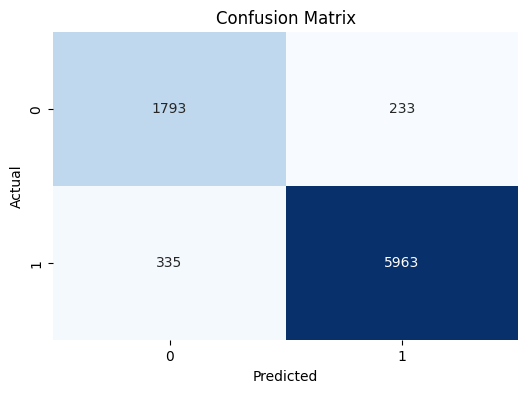

In [102]:
numSamples = 10
tester = []

beeOrNot, images, labels = classifyInsects(1, "Bee")
sample = random.sample(range(len(images)), numSamples)
for index in sample:
    tester.append((images[index], labels[index]))

waspOrNot, images, labels = classifyInsects(2, "Wasp")
sample = random.sample(range(len(images)), numSamples)
for index in sample:
    tester.append((images[index], labels[index]))


In [115]:

for modelName in beeOrNot.keys():
    print('-'*50,f'\n{modelName}\n','-'*50)
    
    for image, label in tester:
        
        demo(beeOrNot[modelName], waspOrNot[modelName], image, label)

-------------------------------------------------- 
VGG
 --------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
[[          1]]
Predicted: Bee
True label: Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
[[  3.047e-06]]
Predicted: Not Bee
True label: Not Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
[[     0.2625]]
Predicted: Other Insects
True label: Other Insects
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
[[ 4.5298e-07]]
Predicted: Not Bee
True label: Not Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
[[ 4.2183e-06]]
Predicted: Other Insects
True label: Other Insects
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
[[          1]]
Predicted: Bee
True label: Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
[[   0.061121]]
Predicted: Not Bee
True label: Not Bee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237